In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="7"

Sat Jan 27 17:25:47 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   43C    P0    47W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [5]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [6]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [7]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [9]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if True:
    step, model_list, optimizer_list = load_model_list(save_dir, 660000, model_list, optimizer_list)

total 623352
-rw-rw-r-- 1 scpark scpark        0  1월 27 17:25 events.out.tfevents.1706343951.GPUSVR11
-rw-rw-r-- 1 scpark scpark 99803059  1월 26 12:23 events.out.tfevents.1706177345.GPUSVR11
-rw-rw-r-- 1 scpark scpark  7479121  1월 26 12:08 save_660000
-rw-rw-r-- 1 scpark scpark  7479121  1월 26 11:52 save_650000
-rw-rw-r-- 1 scpark scpark  7479121  1월 26 11:50 save_648715
-rw-rw-r-- 1 scpark scpark  7479121  1월 26 11:36 save_640000
-rw-rw-r-- 1 scpark scpark  7479121  1월 26 11:21 save_630000
-rw-rw-r-- 1 scpark scpark  7479121  1월 26 11:06 save_620000
-rw-rw-r-- 1 scpark scpark  7479121  1월 26 10:50 save_610000
-rw-rw-r-- 1 scpark scpark  7479121  1월 26 10:35 save_600000
-rw-rw-r-- 1 scpark scpark  7479121  1월 26 10:19 save_590000
-rw-rw-r-- 1 scpark scpark  7479121  1월 26 10:04 save_580000
-rw-rw-r-- 1 scpark scpark  7479121  1월 26 09:48 save_570000
-rw-rw-r-- 1 scpark scpark  7479121  1월 26 09:33 save_560000
-rw-rw-r-- 1 scpark scpark  7479121  1월 26 09:18 save_550000
-rw-rw-r-- 1 scp

### Dataset

In [10]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [11]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [12]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [13]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

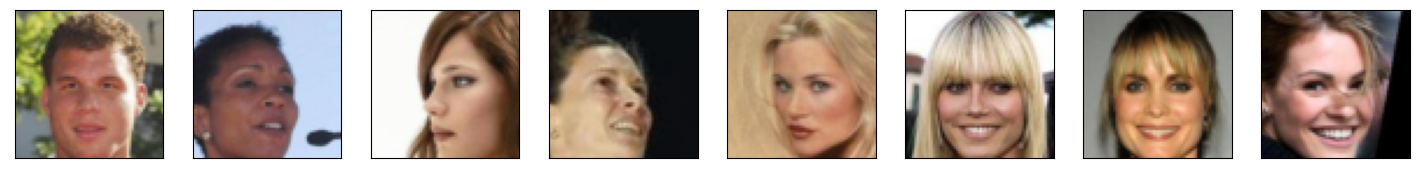

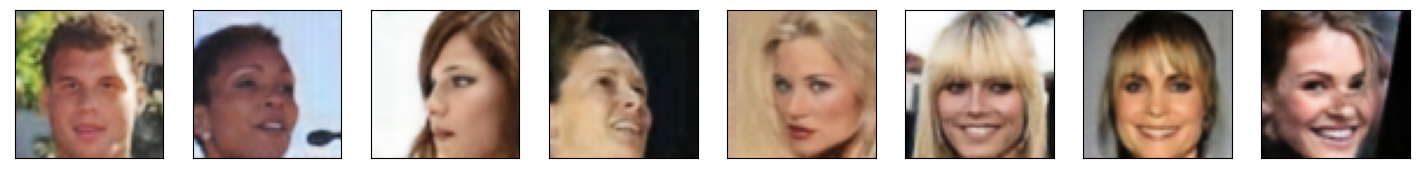

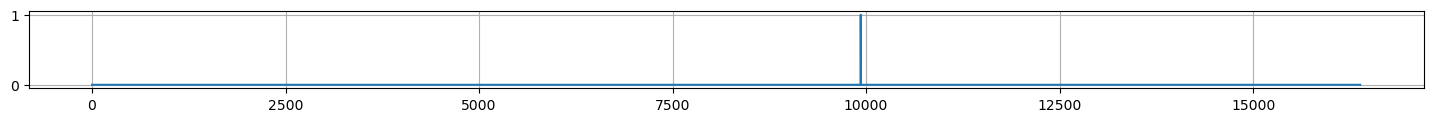

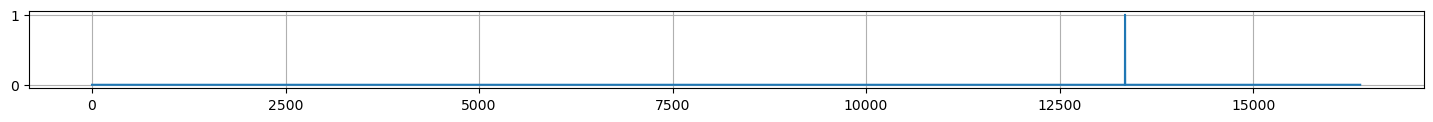

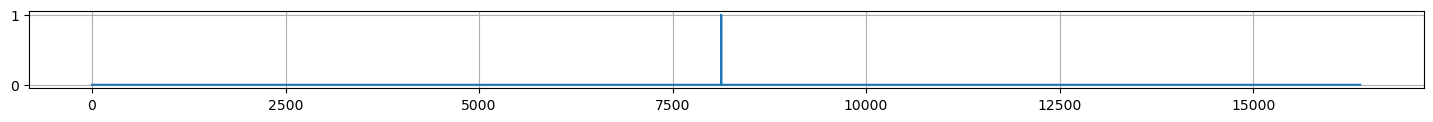

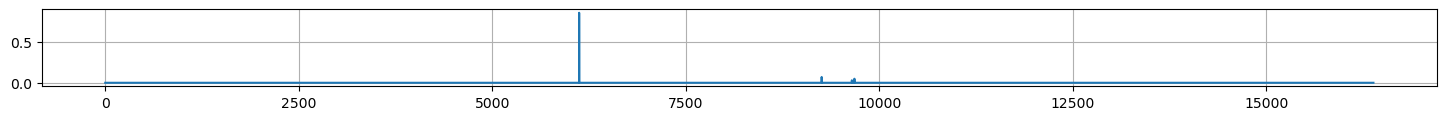

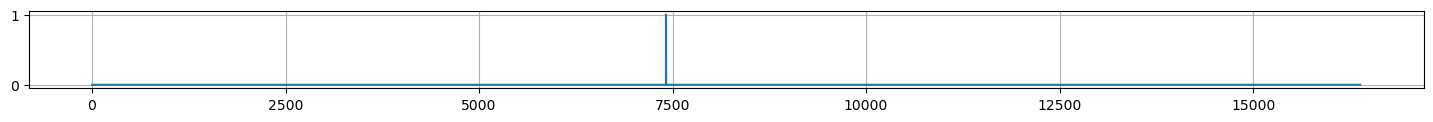

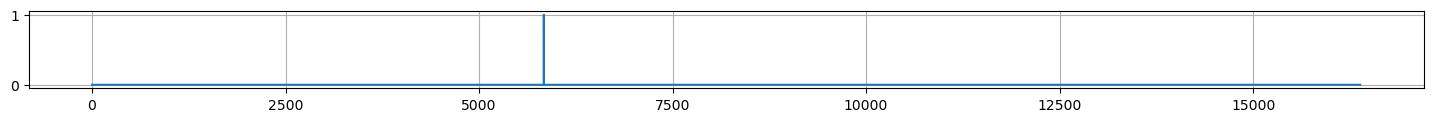

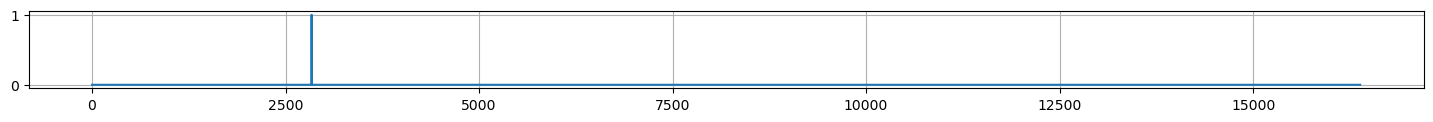

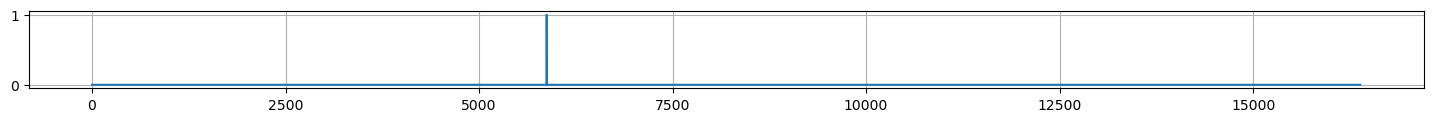

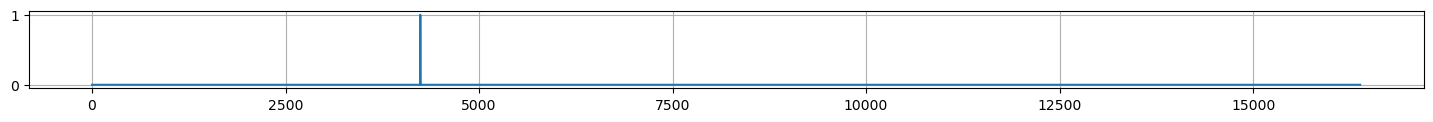

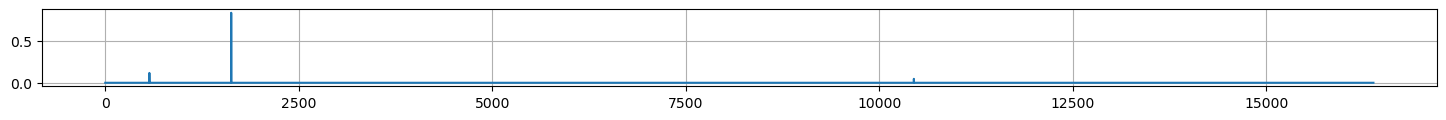

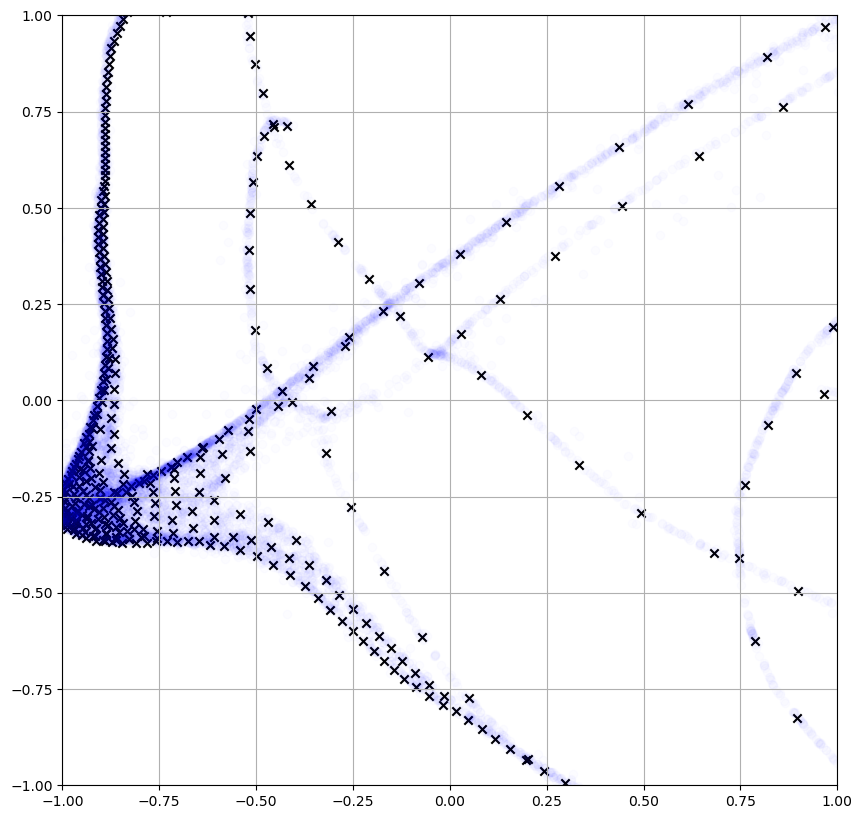

661001
lse_loss -387.40533447265625
commit_loss 0.00014991940406616777
recon_loss 0.000790479127317667
661002
lse_loss -393.0225524902344
commit_loss 0.00014375997125171125
recon_loss 0.0008050976321101189
661003
lse_loss -394.9286193847656
commit_loss 0.0001441159110981971
recon_loss 0.0008293015416711569
661004
lse_loss -391.4275817871094
commit_loss 0.0001538197830086574
recon_loss 0.0008156063267961144
661005
lse_loss -391.56927490234375
commit_loss 0.0001601777330506593
recon_loss 0.0008001126116141677
661006
lse_loss -385.6373291015625
commit_loss 0.0001467856200179085
recon_loss 0.0009334967471659184
661007
lse_loss -383.80755615234375
commit_loss 0.00015869851631578058
recon_loss 0.0008356777834706008
661008
lse_loss -393.90240478515625
commit_loss 0.0001565035927342251
recon_loss 0.0007038147887215018
661009
lse_loss -394.2148132324219
commit_loss 0.0001407091476721689
recon_loss 0.0007130339508876204
661010
lse_loss -391.1013488769531
commit_loss 0.00013603325351141393
recon_

lse_loss -396.3890380859375
commit_loss 0.0001476862671552226
recon_loss 0.0007033307920210063
661084
lse_loss -397.06134033203125
commit_loss 0.00016217910160776228
recon_loss 0.0007201768457889557
661085
lse_loss -401.7917175292969
commit_loss 0.00015391738270409405
recon_loss 0.0006769832689315081
661086
lse_loss -402.6435546875
commit_loss 0.00015742536925245076
recon_loss 0.0007210124167613685
661087
lse_loss -400.5776062011719
commit_loss 0.00014910934260115027
recon_loss 0.0008174252579919994
661088
lse_loss -400.4628601074219
commit_loss 0.0001392765116179362
recon_loss 0.0007906925748102367
661089
lse_loss -398.4972229003906
commit_loss 0.00013890306581743062
recon_loss 0.0009132631821557879
661090
lse_loss -396.2269287109375
commit_loss 0.00016625459829811007
recon_loss 0.000831549521535635
661091
lse_loss -397.1006164550781
commit_loss 0.00017110798216890544
recon_loss 0.0007106541888788342
661092
lse_loss -397.9991455078125
commit_loss 0.00019069627160206437
recon_loss 0.00

lse_loss -394.59539794921875
commit_loss 0.00015637814067304134
recon_loss 0.0007689539343118668
661164
lse_loss -396.6918029785156
commit_loss 0.00013762532034888864
recon_loss 0.0006791581399738789
661165
lse_loss -396.5267639160156
commit_loss 0.00016360028530471027
recon_loss 0.000690571847371757
661166
lse_loss -397.8204650878906
commit_loss 0.00015456945402547717
recon_loss 0.0007228930480778217
661167
lse_loss -392.05084228515625
commit_loss 0.0001586830912856385
recon_loss 0.0007833874551579356
661168
lse_loss -390.3498840332031
commit_loss 0.00014663119509350508
recon_loss 0.000751376326661557
661169
lse_loss -397.1017150878906
commit_loss 0.00016532752488274127
recon_loss 0.0006701039965264499
661170
lse_loss -401.130615234375
commit_loss 0.00016638838860671967
recon_loss 0.0006894002435728908
661171
lse_loss -387.8089294433594
commit_loss 0.00019254826474934816
recon_loss 0.0008326005190610886
661172
lse_loss -402.80731201171875
commit_loss 0.0001591409236425534
recon_loss 0

lse_loss -400.01812744140625
commit_loss 0.0001586862636031583
recon_loss 0.000784676696639508
661244
lse_loss -399.3117370605469
commit_loss 0.0001674595259828493
recon_loss 0.0008085977169685066
661245
lse_loss -392.8486022949219
commit_loss 0.00017107930034399033
recon_loss 0.0007024858496151865
661246
lse_loss -396.94976806640625
commit_loss 0.00016345990297850221
recon_loss 0.0007499723578803241
661247
lse_loss -399.6596984863281
commit_loss 0.0001542162790428847
recon_loss 0.000772839121054858
661248
lse_loss -399.6342468261719
commit_loss 0.00016344053437933326
recon_loss 0.0007310555665753782
661249
lse_loss -394.8040771484375
commit_loss 0.00016293911903630942
recon_loss 0.0007110407459549606
661250
lse_loss -394.5458679199219
commit_loss 0.0001606924633961171
recon_loss 0.0008887855219654739
661251
lse_loss -394.3457336425781
commit_loss 0.0001518036879133433
recon_loss 0.0007964398246258497
661252
lse_loss -388.04266357421875
commit_loss 0.00018499259022064507
recon_loss 0.0

lse_loss -391.6519470214844
commit_loss 0.00014353783626575023
recon_loss 0.0008028093143366277
661326
lse_loss -392.4325866699219
commit_loss 0.00014313908468466252
recon_loss 0.000746608420740813
661327
lse_loss -397.3979187011719
commit_loss 0.0001449094561394304
recon_loss 0.0007792137912474573
661328
lse_loss -397.98785400390625
commit_loss 0.00013886419765185565
recon_loss 0.0008085871813818812
661329
lse_loss -395.246337890625
commit_loss 0.00014442962128669024
recon_loss 0.0008375032339245081
661330
lse_loss -397.16522216796875
commit_loss 0.00014122427091933787
recon_loss 0.0008081528358161449
661331
lse_loss -397.4978332519531
commit_loss 0.0001510583097115159
recon_loss 0.0008556018583476543
661332
lse_loss -402.8638610839844
commit_loss 0.00014308835670817643
recon_loss 0.0007289483910426497
661333
lse_loss -397.6417541503906
commit_loss 0.00013137557834852487
recon_loss 0.000881546875461936
661334
lse_loss -399.0738220214844
commit_loss 0.00015467999037355185
recon_loss 0.

lse_loss -400.09136962890625
commit_loss 0.00013956351904198527
recon_loss 0.0007097219931893051
661406
lse_loss -397.92205810546875
commit_loss 0.00014444583212025464
recon_loss 0.0007961433148011565
661407
lse_loss -399.9997253417969
commit_loss 0.00013111819862388074
recon_loss 0.0007857639575377107
661408
lse_loss -401.8951110839844
commit_loss 0.0001275545364478603
recon_loss 0.0007777400314807892
661409
lse_loss -394.86676025390625
commit_loss 0.0001239078410435468
recon_loss 0.0006551131955347955
661410
lse_loss -390.4595642089844
commit_loss 0.00013385176134761423
recon_loss 0.0007845705840736628
661411
lse_loss -396.9093017578125
commit_loss 0.00012917611456941813
recon_loss 0.0007251358474604785
661412
lse_loss -389.9356994628906
commit_loss 0.00012296548811718822
recon_loss 0.0007060195785015821
661413
lse_loss -393.536865234375
commit_loss 0.00013954774476587772
recon_loss 0.0007539891521446407
661414
lse_loss -389.11865234375
commit_loss 0.00015863284352235496
recon_loss 0

661488
lse_loss -399.1661682128906
commit_loss 0.00014223274774849415
recon_loss 0.0007320347940549254
661489
lse_loss -401.4083557128906
commit_loss 0.00013083861267659813
recon_loss 0.0007618897943757474
661490
lse_loss -397.4310607910156
commit_loss 0.00014305292279459536
recon_loss 0.000811220146715641
661491
lse_loss -401.364501953125
commit_loss 0.00015271187294274569
recon_loss 0.0008353347657248378
661492
lse_loss -395.46832275390625
commit_loss 0.00013390491949394345
recon_loss 0.0006424838211387396
661493
lse_loss -394.7220458984375
commit_loss 0.00014350502169691026
recon_loss 0.0007529477588832378
661494
lse_loss -397.1780700683594
commit_loss 0.00014459810336120427
recon_loss 0.0007265905733220279
661495
lse_loss -378.9131164550781
commit_loss 0.0001540908997412771
recon_loss 0.0007656707894057035
661496
lse_loss -394.91156005859375
commit_loss 0.00014124052540864795
recon_loss 0.0007949468563310802
661497
lse_loss -395.962890625
commit_loss 0.00013668743486050516
recon_lo

661568
lse_loss -384.11181640625
commit_loss 0.0001721283479128033
recon_loss 0.0007455634768120944
661569
lse_loss -395.2323303222656
commit_loss 0.00015025190077722073
recon_loss 0.0008267894154414535
661570
lse_loss -395.0058288574219
commit_loss 0.00014092146011535078
recon_loss 0.0007994569605216384
661571
lse_loss -388.7666015625
commit_loss 0.00016412202967330813
recon_loss 0.0008163710008375347
661572
lse_loss -392.2781982421875
commit_loss 0.00014683674089610577
recon_loss 0.0006689074216410518
661573
lse_loss -392.81475830078125
commit_loss 0.00015679009084124118
recon_loss 0.0008143378654494882
661574
lse_loss -396.5359191894531
commit_loss 0.00016241254343185574
recon_loss 0.0008314518490806222
661575
lse_loss -389.9932861328125
commit_loss 0.00014375036698766053
recon_loss 0.000877699232660234
661576
lse_loss -386.1161804199219
commit_loss 0.00014026639109943062
recon_loss 0.0007388269295915961
661577
lse_loss -387.00579833984375
commit_loss 0.0001559286320116371
recon_los

661648
lse_loss -401.4542541503906
commit_loss 0.00014138652477413416
recon_loss 0.0008655681158415973
661649
lse_loss -401.1988220214844
commit_loss 0.0001481272338423878
recon_loss 0.0009979847818613052
661650
lse_loss -397.6663513183594
commit_loss 0.00015544146299362183
recon_loss 0.0008502835407853127
661651
lse_loss -398.4194641113281
commit_loss 0.00014928629389032722
recon_loss 0.0007527237758040428
661652
lse_loss -397.1571960449219
commit_loss 0.00015261983207892627
recon_loss 0.0008742191712372005
661653
lse_loss -396.6246643066406
commit_loss 0.00015742013056296855
recon_loss 0.0008444531704299152
661654
lse_loss -400.6316223144531
commit_loss 0.0001554326736368239
recon_loss 0.0008664058404974639
661655
lse_loss -399.7090148925781
commit_loss 0.00014816984185017645
recon_loss 0.0008309173863381147
661656
lse_loss -401.4886779785156
commit_loss 0.00015761455870233476
recon_loss 0.000788747682236135
661657
lse_loss -399.2239685058594
commit_loss 0.00015005809837020934
recon_

661729
lse_loss -389.9501647949219
commit_loss 0.00013564596883952618
recon_loss 0.000808294746093452
661730
lse_loss -396.4827880859375
commit_loss 0.0001346019998891279
recon_loss 0.0007140146335586905
661731
lse_loss -396.01324462890625
commit_loss 0.00015046788030304015
recon_loss 0.0007419682806357741
661732
lse_loss -401.1633605957031
commit_loss 0.00015469548816327006
recon_loss 0.0006574096041731536
661733
lse_loss -400.0932922363281
commit_loss 0.00015255616744980216
recon_loss 0.0006421823054552078
661734
lse_loss -392.3662109375
commit_loss 0.00015041933511383832
recon_loss 0.0007812371477484703
661735
lse_loss -395.11053466796875
commit_loss 0.0001611488696653396
recon_loss 0.0007622728007845581
661736
lse_loss -395.3117370605469
commit_loss 0.00013963777746539563
recon_loss 0.0007426897063851357
661737
lse_loss -394.4884033203125
commit_loss 0.00014617739361710846
recon_loss 0.0007375708664767444
661738
lse_loss -388.19842529296875
commit_loss 0.00014110728807281703
recon_

661811
lse_loss -399.4635925292969
commit_loss 0.0001535597548354417
recon_loss 0.0008051834302023053
661812
lse_loss -396.856689453125
commit_loss 0.00015453642117790878
recon_loss 0.0008097023237496614
661813
lse_loss -397.50274658203125
commit_loss 0.00014533083594869822
recon_loss 0.0008594535756856203
661814
lse_loss -397.534912109375
commit_loss 0.0001574150228407234
recon_loss 0.0007490323623642325
661815
lse_loss -383.19891357421875
commit_loss 0.00014844004181213677
recon_loss 0.0008680074824951589
661816
lse_loss -386.0637512207031
commit_loss 0.0001526469422969967
recon_loss 0.0007589452434331179
661817
lse_loss -395.3573303222656
commit_loss 0.0001386611838825047
recon_loss 0.0009220530628226697
661818
lse_loss -394.42816162109375
commit_loss 0.0001672593061812222
recon_loss 0.0008300069021061063
661819
lse_loss -383.9916687011719
commit_loss 0.00015847015311010182
recon_loss 0.0007068889099173248
661820
lse_loss -393.0148620605469
commit_loss 0.0001612465421203524
recon_lo

661891
lse_loss -394.7682800292969
commit_loss 0.00013129733270034194
recon_loss 0.0007917300099506974
661892
lse_loss -382.7318420410156
commit_loss 0.00015219501801766455
recon_loss 0.0007063233060762286
661893
lse_loss -389.14697265625
commit_loss 0.00014910049503669143
recon_loss 0.0007845673244446516
661894
lse_loss -390.4931945800781
commit_loss 0.00016578033682890236
recon_loss 0.0007706281030550599
661895
lse_loss -397.1249694824219
commit_loss 0.00014616454427596182
recon_loss 0.0007826220244169235
661896
lse_loss -396.4518737792969
commit_loss 0.00014028657460585237
recon_loss 0.0007298698183149099
661897
lse_loss -397.4623718261719
commit_loss 0.0001473882293794304
recon_loss 0.0008060061372816563
661898
lse_loss -400.0033874511719
commit_loss 0.00015034739044494927
recon_loss 0.0007896155584603548
661899
lse_loss -395.85028076171875
commit_loss 0.0001388902892358601
recon_loss 0.0008082295535132289
661900
lse_loss -395.28594970703125
commit_loss 0.00015337232616730034
recon

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-4
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')